In [1]:
# import libriares and indpendies
import numpy as np
import pandas as pd
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


/opt/anaconda3/envs/fintech/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df = web.DataReader('AAPL', data_source="yahoo", start= '2010/01/01', end='2020/04/10')
df

High         Low        Open       Close       Volume  \
Date                                                                      
2010-01-04   30.642857   30.340000   30.490000   30.572857  123432400.0   
2010-01-05   30.798571   30.464285   30.657143   30.625713  150476200.0   
2010-01-06   30.747143   30.107143   30.625713   30.138571  138040000.0   
2010-01-07   30.285715   29.864286   30.250000   30.082857  119282800.0   
2010-01-08   30.285715   29.865715   30.042856   30.282858  111902700.0   
...                ...         ...         ...         ...          ...   
2020-04-03  245.699997  238.970001  242.800003  241.410004   32470000.0   
2020-04-06  263.109985  249.380005  250.899994  262.470001   50455100.0   
2020-04-07  271.700012  259.000000  270.799988  259.429993   50721800.0   
2020-04-08  267.369995  261.230011  262.739990  266.070007   42223800.0   
2020-04-09  270.070007  264.700012  268.700012  267.989990   40529100.0   

             Adj Close  
Date                    
2010-01-04   26.538483  
2010-01-05   26.584366  
2010-01-06   26.161509  
2010-01-07   26.113146  
2010-01-08   26.286753  
...                ...  
2020-04-03  241.410004  
2020-04-06  262.470001  
2020-04-07  259.429993  
2020-04-08  266.070007  
2020-04-09  267.989990  

[2585 rows x 6 columns]

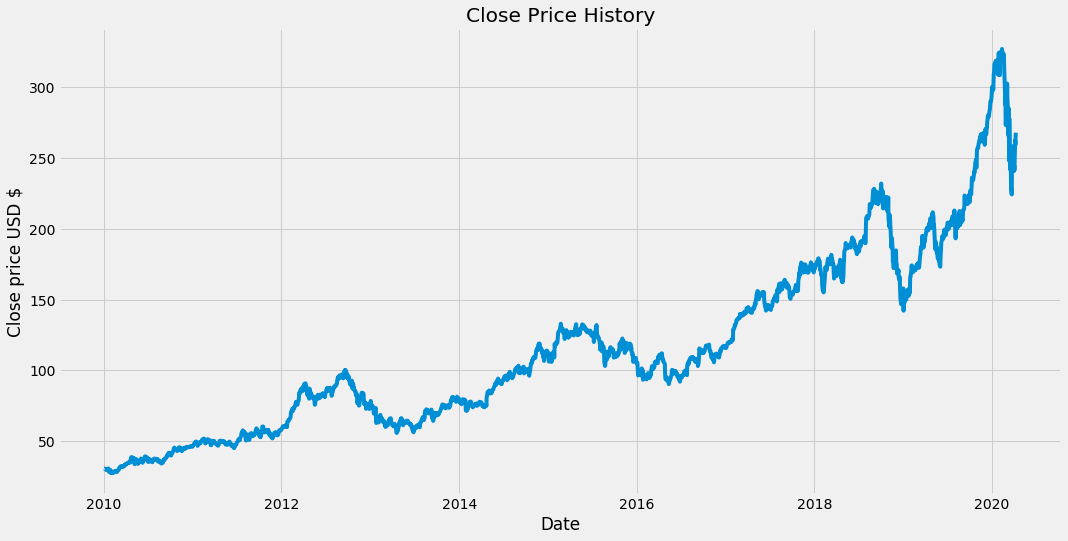

In [3]:
# visulaize the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df["Close"])
plt.xlabel('Date')
plt.ylabel('Close price USD $')
plt.show()

In [4]:
# create a new dataframe with only close column
data = df.filter(['Close'])
#convet the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

2068

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
#Creat the training data set
#creat the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into X_train and y_train data set
X_train= []
y_train = []

for i in range (30, len(train_data)):
  X_train.append(train_data[i-30:i,0])   #will contain 60 values. index 0 to 59
  y_train.append(train_data[i,0]) #will conrain 61st value.  index 60
  

In [7]:
#convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [1]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_train.shape

NameError: name 'X_train' is not defined

In [33]:
# Bulid the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences= True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(100, return_sequences= False))
model.add(Dense(50))
model.add(Dense(1))

In [34]:
#Complie model
model.compile(optimizer='adam', loss='mean_squared_error')  #loss show how well the model did in training

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size= 1, epochs=1)

Train on 2038 samples
1837/2038 [==========================>...] - ETA: 8s - loss: 5.4129e-04

In [ ]:
#create the teating data set
#create a new array containing scaled values from index  
test_data = scaled_data[training_data_len - 30:,:]
#Create the data sets X_test and y_test
X_test = []
y_test= dataset[training_data_len:,:]
for i in range(30, len(test_data)):
    X_test.append(test_data[i-30:i,0])


In [ ]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [ ]:
# Reshape the data
X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
#Get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


In [ ]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visulize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel('Close Price USD $')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(["Train", 'Val','Predictions'])
plt.show()

In [ ]:
# show the valid and predicted prices
valid

In [ ]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start = '2000/01/01', end= '2020/04/08')
#creat a data frame
new_df = apple_quote.filter(['Close'])
#Get the last 120 day clsoing price values and convert the dataframe to an array
last_60_days = new_df[-30:].values
#Scale the data to ve values between 0 and 1
last_60_scaled = scaler.transform(last_60_days)
#creat an empty list
x_test = []
# Append the past 120 days
x_test.append(last_60_scaled)
# convert the x_test data set to numpy array
x_test = np.array(x_test)
# Reshape
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
# Get the predicted scaled price
pred_price = model.predict(x_test)
#undo the scaling
pred_price= scaler.inverse_transform(pred_price)
print(pred_price)

In [21]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start = '2020/04/06', end= '2020/04/10')
print(apple_quote2['Close'])

Date
2020-04-06    262.470001
2020-04-07    259.429993
2020-04-08    266.070007
2020-04-09    267.989990
Name: Close, dtype: float64
